In [ ]:
import pandas as pd
from collections import Counter
    

def get_trigrams(w):
    return ["".join(t) for t in zip(w[:-2], w[1:-1], w[2:])]

def get_bigrams(w):
    return ["".join(t) for t in zip(w[:-1], w[1])]

def get_unigrams(w):
    return list(w)

def get_train_ngram_freqs(train_fn, n=3):
    freqs = Counter()
    with open(train_fn, "r") as f:
        for line in f:
            lem, msd, form = line.rstrip().split("\t")
            tris = set(get_trigrams(lem))
            tris = tris.union(set(get_trigrams(form)))
            freqs += Counter(tris)

    return freqs


def get_trigram_freq_by_error(train_tri_freqs, pred_fn):
    """Counts number of dev examples containing a trigram, and number of
    incorrect examples containing that trigram"""
    dev_sample_counts = Counter()
    dev_sample_error_counts = Counter()
    with open(pred_fn, "r") as f:
        for line in f:
            lem, msd, form, pred = line.rstrip().split("\t")
            trigrams = set(get_trigrams(lem))
            trigrams = trigrams.union(set(get_trigrams(form)))
            for t in trigrams:
                dev_sample_counts[t] += 1
                if form != pred:
                    dev_sample_error_counts[t] += 1

    return {t: {
        "train_freq": train_tri_freqs[t],
        "dev_sample_counts": dev_sample_counts[t],
        "dev_sample_error_counts": dev_sample_error_counts[t],
    } for t in list(train_tri_freqs.keys()) + list(dev_sample_counts.keys())}



train_fn = "../../yoyodyne/data/sig-2023/deu.trn"
pred_fn = "../../yoyodyne/2023_eval/deu_dev_postproc_dec_side_by_side.preds"
tri_train_freqs = get_train_ngram_freqs(train_fn, n=3)
all = get_trigram_freq_by_error(tri_train_freqs, pred_fn)
df = pd.DataFrame(all).T
df["error_rate"] = df["dev_sample_error_counts"] / df["dev_sample_counts"]
df = df.fillna(-1)
df.head()

<AxesSubplot:>

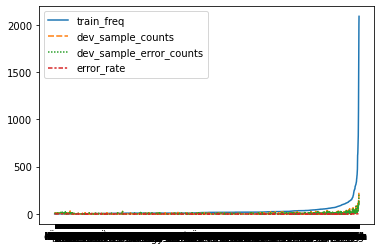

In [2]:
import seaborn as sns

sns.lineplot(df.sort_values("train_freq"))

In [3]:
df = df.loc[df["error_rate"] > -1]
df.head()

,train_freq,dev_sample_counts,dev_sample_error_counts,error_rate
ach,134,45,40,0.888889
end,293,32,29,0.906250
mac,35,8,8,1.000000
hen,631,21,21,1.000000
che,654,25,20,0.800000


In [4]:
df["train_freq"].corr(df["error_rate"], method="spearman")

-0.1877716952906819

In [5]:
df["train_freq"].corr(df["dev_sample_counts"])

0.8918973989042442

<AxesSubplot:xlabel='train_freq', ylabel='Count'>

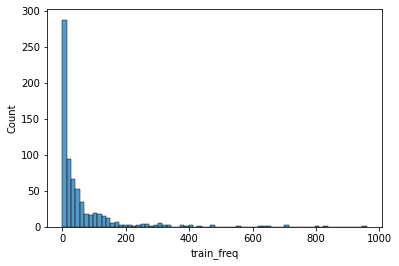

In [6]:
sns.histplot(data=df.loc[df["train_freq"] < 1000], x="train_freq")

<AxesSubplot:xlabel='error_rate', ylabel='Count'>

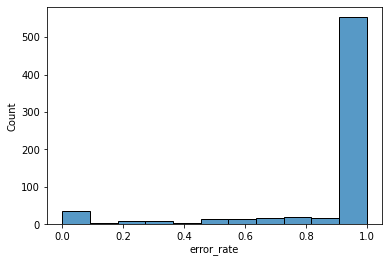

In [7]:
sns.histplot(data=df, x="error_rate")

<AxesSubplot:xlabel='train_freq', ylabel='error_rate'>

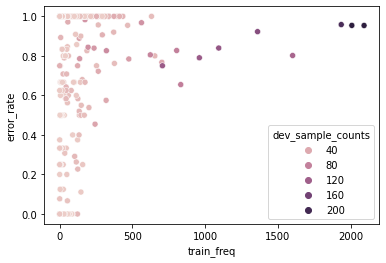

In [8]:
sns.scatterplot(data=df, x="train_freq", y="error_rate", hue="dev_sample_counts")

<AxesSubplot:xlabel='train_freq', ylabel='error_rate'>

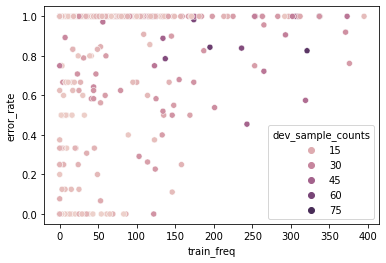

In [9]:
sns.scatterplot(data=df.loc[df["train_freq"] < 400], x="train_freq", y="error_rate", hue="dev_sample_counts")

In [10]:
with open(pred_fn, "r") as f:
    for line in f:
        lem, msd, form, pred = line.rstrip().split("\t")
        trigrams = set(get_trigrams(lem))
        trigrams = trigrams.union(set(get_trigrams(form)))
        if any(tri_train_freqs[t] == 0 for t in trigrams) and form == pred:
            print([t for t in trigrams if tri_train_freqs[t] == 0])
            print(lem, msd, form, pred)

['Mac']
Macher N;ACC(SG) Macher Macher
['Mac']
Macher N;DAT(PL) Machern Machern
['Mac']
Macher N;DAT(SG) Macher Macher
['Mac']
Macher N;GEN(SG) Machers Machers
['Mac']
Macher N;NOM(SG) Macher Macher
['Sna']
Snack N;ACC(SG) Snack Snack
['Sna']
Snack N;DAT(SG) Snack Snack
['Sna']
Snack N;NOM(SG) Snack Snack
['lse']
Wels N;ACC(PL) Welse Welse
['lse']
Wels N;GEN(PL) Welse Welse
['lse']
Wels N;GEN(SG) Welses Welses
['lse']
Wels N;NOM(PL) Welse Welse
['eß ', 'ß a']
ausschließen V;IMP;NOM(2,SG) schließ aus schließ aus
['fti', 'äft']
beschäftigen V;IMP;NOM(2,PL) beschäftigt beschäftigt
['fti', 'äft']
beschäftigen V;IND;PRS;NOM(2,SG) beschäftigst beschäftigst
['fti', 'äft']
beschäftigen V;IND;PRS;NOM(3,SG) beschäftigt beschäftigt
['fti', 'äft']
beschäftigen V;IND;PST;NOM(1,PL) beschäftigten beschäftigten
['fti', 'äft']
beschäftigen V;IND;PST;NOM(1,SG) beschäftigte beschäftigte
['fti', 'äft']
beschäftigen V;IND;PST;NOM(2,SG) beschäftigtest beschäftigtest
['fti', 'äft']
beschäftigen V;NFIN beschä

# What are the training n-gram distributions of the samples our model gets right v.s. wrong?

- Maybe we get an error rate for every ngram: what % of samples that it appears in do we getwrong?
- Do seperately for lemma and gold output form

In [51]:
dev_lemma_counts = Counter()
dev_lemma_error_counts = Counter()
with open(pred_fn, "r") as f:
    for line in f:
        lem, msd, form, pred = line.rstrip().split("\t")
        trigrams = set(get_trigrams(lem))
        bigrams = set(get_bigrams(lem))
        unigrams = set(get_unigrams(lem))
        for t in list(unigrams) + list(bigrams) + list(trigrams):
            dev_lemma_counts[t] += 1
            if form != pred:
                dev_lemma_error_counts[t] += 1
                
def get_train_lemma_ngram_freqs(train_fn, n=3):
    freqs = Counter()
    with open(train_fn, "r") as f:
        for line in f:
            lem, msd, form = line.rstrip().split("\t")
            if n == 3:
                ngrams = set(get_trigrams(lem))
            if n == 2:
                ngrams = set(get_bigrams(lem))
            if n == 1:
                ngrams = set(get_unigrams(lem))
            freqs += Counter(ngrams)

    return freqs

train_uni = get_train_lemma_ngram_freqs(train_fn, n=1)
train_bi = get_train_lemma_ngram_freqs(train_fn, n=2)
train_tri = get_train_lemma_ngram_freqs(train_fn, n=3)

a = {}
train_freqs =  {**train_uni, **train_bi, **train_tri}
for t in dev_lemma_counts:
    a[t] = {
        "dev_lemma_count": dev_lemma_counts[t],
        "dev_lemma_error_count": dev_lemma_error_counts[t],
        "train_freq": train_freqs.get(t, 0),
        "dev_lemma_error_rate": dev_lemma_error_counts.get(t, 0) / dev_lemma_counts[t],
    }
errors_df = pd.DataFrame(a).T
errors_df["ngram"] = ""
errors_df.loc[errors_df[[len(s) < 2 for s in errors_df.index]].index, "ngram"] = "uni"
errors_df.loc[errors_df[[len(s) == 2 for s in errors_df.index]].index, "ngram"] = "bi"
errors_df.loc[errors_df[[len(s) == 3 for s in errors_df.index]].index, "ngram"] = "tri"
errors_df

,dev_lemma_count,dev_lemma_error_count,train_freq,dev_lemma_error_rate,ngram
n,836.0,723.0,8609.0,0.864833,uni
a,416.0,360.0,3560.0,0.865385,uni
m,140.0,129.0,1665.0,0.921429,uni
b,212.0,173.0,1956.0,0.816038,uni
c,272.0,238.0,2161.0,0.875000,uni
...,...,...,...,...,...
Öl,8.0,8.0,0.0,1.000000,bi
lfa,8.0,8.0,26.0,1.000000,tri
Ölf,8.0,8.0,0.0,1.000000,tri
fas,8.0,8.0,0.0,1.000000,tri


<AxesSubplot:xlabel='train_freq', ylabel='dev_lemma_error_rate'>

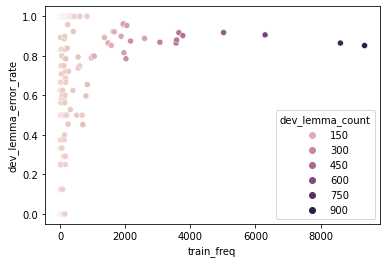

In [52]:
sns.scatterplot(
    data=errors_df.sort_values("train_freq"),
    x = "train_freq",
    y = "dev_lemma_error_rate",
    hue = "dev_lemma_count"
)

In [24]:
errors_df.loc[errors_df["dev_lemma_error_rate"] < 0.2]

,dev_lemma_count,dev_lemma_error_count,train_freq,dev_lemma_error_rate
hau,4.0,0.0,68.0,0.000
omo,8.0,1.0,25.0,0.125
Pom,8.0,1.0,7.0,0.125
mol,8.0,1.0,15.0,0.125
Se,8.0,0.0,55.0,0.000
gel,8.0,0.0,140.0,0.000
Seg,8.0,0.0,8.0,0.000
W,8.0,1.0,75.0,0.125
We,8.0,1.0,17.0,0.125
Wel,8.0,1.0,3.0,0.125


In [25]:
errors_df.loc[errors_df["dev_lemma_error_rate"] > 0.9]

,dev_lemma_count,dev_lemma_error_count,train_freq,dev_lemma_error_rate
m,140.0,129.0,1665.0,0.921429
A,52.0,48.0,401.0,0.923077
hun,8.0,8.0,23.0,1.000000
ung,24.0,24.0,253.0,1.000000
bma,8.0,8.0,0.0,1.000000
...,...,...,...,...
Öl,8.0,8.0,0.0,1.000000
lfa,8.0,8.0,26.0,1.000000
Ölf,8.0,8.0,0.0,1.000000
fas,8.0,8.0,0.0,1.000000


<AxesSubplot:xlabel='train_freq', ylabel='dev_lemma_error_rate'>

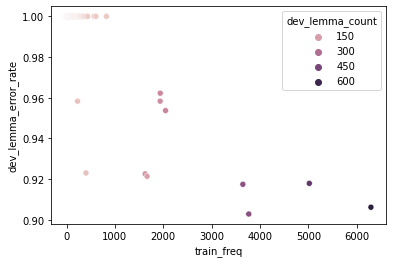

In [27]:
sns.scatterplot(
    data=errors_df.loc[errors_df["dev_lemma_error_rate"] > 0.9].sort_values("train_freq"),
    x = "train_freq",
    y = "dev_lemma_error_rate",
    hue = "dev_lemma_count"
)

In [38]:
errors_df.loc[errors_df["train_freq"] < 1]

,dev_lemma_count,dev_lemma_error_count,train_freq,dev_lemma_error_rate
bma,8.0,8.0,0.0,1.0
Abm,8.0,8.0,0.0,1.0
Alp,8.0,8.0,0.0,1.0
yri,16.0,16.0,0.0,1.0
ssy,8.0,8.0,0.0,1.0
...,...,...,...,...
tör,12.0,12.0,0.0,1.0
Ö,8.0,8.0,0.0,1.0
Öl,8.0,8.0,0.0,1.0
Ölf,8.0,8.0,0.0,1.0


In [33]:
uni_errors_df = errors_df[[len(s) < 2 for s in errors_df.index]]
uni_errors_df

,dev_lemma_count,dev_lemma_error_count,train_freq,dev_lemma_error_rate
n,836.0,723.0,8609.0,0.864833
a,416.0,360.0,3560.0,0.865385
m,140.0,129.0,1665.0,0.921429
b,212.0,173.0,1956.0,0.816038
c,272.0,238.0,2161.0,0.875000
A,52.0,48.0,401.0,0.923077
h,344.0,299.0,3064.0,0.869186
u,188.0,167.0,2591.0,0.888298
g,280.0,220.0,2020.0,0.785714
s,400.0,367.0,3646.0,0.917500


<AxesSubplot:xlabel='train_freq', ylabel='dev_lemma_error_rate'>

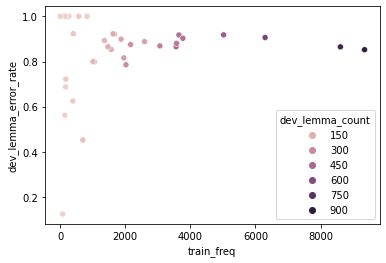

In [35]:
sns.scatterplot(
    data=uni_errors_df,
    x="train_freq",
    y="dev_lemma_error_rate",
    hue="dev_lemma_count"
)

<AxesSubplot:xlabel='train_freq', ylabel='dev_lemma_error_rate'>

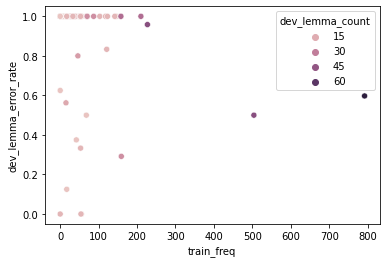

In [36]:
sns.scatterplot(
    data=errors_df[[len(s) == 2 for s in errors_df.index]],
    x="train_freq",
    y="dev_lemma_error_rate",
    hue="dev_lemma_count"
)

<AxesSubplot:xlabel='train_freq', ylabel='dev_lemma_error_rate'>

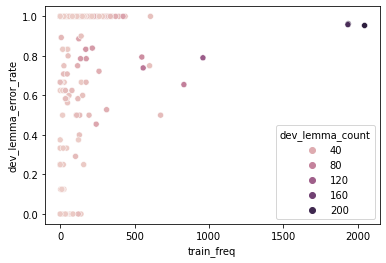

In [37]:
sns.scatterplot(
    data=errors_df[[len(s) == 3 for s in errors_df.index]],
    x="train_freq",
    y="dev_lemma_error_rate",
    hue="dev_lemma_count"
)

<AxesSubplot:xlabel='train_freq', ylabel='dev_lemma_error_rate'>

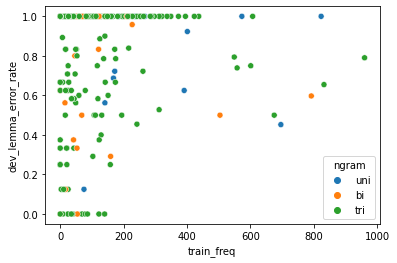

In [45]:
sns.scatterplot(
    data=errors_df.loc[errors_df["train_freq"] < 1000],
    x="train_freq",
    y="dev_lemma_error_rate",
    hue="ngram"
)

In [49]:
dev_form_counts = Counter()
dev_form_error_counts = Counter()
with open(pred_fn, "r") as f:
    for line in f:
        lem, msd, form, pred = line.rstrip().split("\t")
        trigrams = set(get_trigrams(form))
        bigrams = set(get_bigrams(form))
        unigrams = set(get_unigrams(form))
        for t in list(unigrams) + list(bigrams) + list(trigrams):
            dev_form_counts[t] += 1
            if form != pred:
                dev_form_error_counts[t] += 1
                
def get_train_form_ngram_freqs(train_fn, n=3):
    freqs = Counter()
    with open(train_fn, "r") as f:
        for line in f:
            lem, msd, form = line.rstrip().split("\t")
            if n == 3:
                ngrams = set(get_trigrams(form))
            if n == 2:
                ngrams = set(get_bigrams(form))
            if n == 1:
                ngrams = set(get_unigrams(form))
            freqs += Counter(ngrams)

    return freqs

train_uni_form = get_train_form_ngram_freqs(train_fn, n=1)
train_bi_form = get_train_form_ngram_freqs(train_fn, n=2)
train_tri_form = get_train_form_ngram_freqs(train_fn, n=3)

a_form = {}
train_form_freqs =  {**train_uni_form, **train_bi_form, **train_tri_form}
for t in dev_form_counts:
    a_form[t] = {
        "dev_form_count": dev_form_counts[t],
        "dev_form_error_count": dev_form_error_counts[t],
        "train_freq": train_form_freqs.get(t, 0),
        "dev_form_error_rate": dev_form_error_counts.get(t, 0) / dev_form_counts[t],
    }
errors_form_df = pd.DataFrame(a_form).T
errors_form_df["ngram"] = ""
errors_form_df.loc[errors_form_df[[len(s) < 2 for s in errors_form_df.index]].index, "ngram"] = "uni"
errors_form_df.loc[errors_form_df[[len(s) == 2 for s in errors_form_df.index]].index, "ngram"] = "bi"
errors_form_df.loc[errors_form_df[[len(s) == 3 for s in errors_form_df.index]].index, "ngram"] = "tri"
errors_form_df

,dev_form_count,dev_form_error_count,train_freq,dev_form_error_rate,ngram
n,659.0,587.0,5664.0,0.890744,uni
a,401.0,345.0,3460.0,0.860349,uni
m,140.0,129.0,1665.0,0.921429,uni
e,929.0,800.0,9420.0,0.861141,uni
b,212.0,173.0,1956.0,0.816038,uni
...,...,...,...,...,...
Ölf,8.0,8.0,0.0,1.000000,tri
äss,4.0,4.0,1.0,1.000000,tri
lfa,4.0,4.0,26.0,1.000000,tri
fas,4.0,4.0,0.0,1.000000,tri


In [53]:
errors_form_df.loc[errors_form_df["train_freq"] < 1]

,dev_form_count,dev_form_error_count,train_freq,dev_form_error_rate,ngram
bma,8.0,8.0,0.0,1.0,tri
Abm,8.0,8.0,0.0,1.0,tri
Alp,8.0,8.0,0.0,1.0,tri
yri,16.0,16.0,0.0,1.0,tri
ssy,8.0,8.0,0.0,1.0,tri
...,...,...,...,...,...
Öl,8.0,8.0,0.0,1.0,bi
lfä,4.0,4.0,0.0,1.0,tri
fäs,4.0,4.0,0.0,1.0,tri
Ölf,8.0,8.0,0.0,1.0,tri


<AxesSubplot:xlabel='train_freq', ylabel='dev_form_error_rate'>

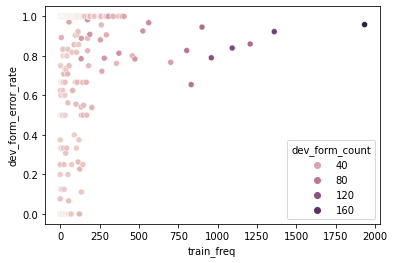

In [57]:
sns.scatterplot(
    data=errors_form_df.loc[errors_form_df["ngram"] == "tri"].sort_values("train_freq"),
    x = "train_freq",
    y = "dev_form_error_rate",
    hue = "dev_form_count"
)

<AxesSubplot:xlabel='train_freq', ylabel='dev_lemma_error_rate'>

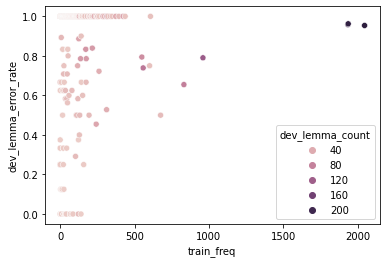

In [60]:
sns.scatterplot(
    data=errors_df.loc[errors_df["ngram"] == "tri"].sort_values("train_freq"),
    x = "train_freq",
    y = "dev_lemma_error_rate",
    hue = "dev_lemma_count"
)

In [66]:
errors_form_df.loc[errors_form_df["ngram"] == "tri"].sort_values("dev_form_count", ascending=False)

,dev_form_count,dev_form_error_count,train_freq,dev_form_error_rate,ngram
ier,192.0,184.0,1934.0,0.958333,tri
ert,142.0,131.0,1360.0,0.922535,tri
rte,131.0,110.0,1093.0,0.839695,tri
sch,124.0,98.0,960.0,0.790323,tri
ten,93.0,80.0,1207.0,0.860215,tri
...,...,...,...,...,...
gew,1.0,1.0,46.0,1.000000,tri
ewi,1.0,1.0,33.0,1.000000,tri
hlä,1.0,1.0,8.0,1.000000,tri
b n,1.0,1.0,0.0,1.000000,tri


In [69]:
errors_form_df_occurring = errors_form_df.loc[
    (errors_form_df["ngram"] == "tri") &
    (errors_form_df["dev_form_count"] > 10) &
    (errors_form_df["dev_form_count"] < 150)
]
errors_form_df_occurring
errors_form_df_occurring["train_freq"].corr(errors_form_df_occurring["dev_form_error_rate"], method="spearman")

-0.17914334775127516

In [74]:
errors_lemma_df_occurring = errors_df.loc[
    (errors_df["ngram"] == "tri") &
    (errors_df["dev_lemma_count"] > 10) &
    (errors_df["dev_lemma_count"] < 150)
]
errors_lemma_df_occurring
errors_lemma_df_occurring["train_freq"].corr(errors_lemma_df_occurring["dev_lemma_error_rate"], method="spearman")

-0.05593728643858537

# Trigram freqs of incorrect predicted trigrams